In [21]:
#importing necessary classes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [22]:
#using pandas to load our dataset, combining the dataset and removing unnecessary columns
data = pd.read_csv("new.csv") 
data2=pd.read_csv('anime.csv')
anime_fulldata=pd.merge(data,data2,on='anime_id',suffixes= ['', '_user'])
anime_fulldata=anime_fulldata.drop(columns=['genre','type','episodes','rating_user','members'])
anime_fulldata = anime_fulldata.rename(columns={'name': 'anime_name',})
anime_fulldata

,user_id,anime_id,rating,anime_name
0,1,20,-1,Naruto
1,3,20,8,Naruto
2,5,20,6,Naruto
3,6,20,-1,Naruto
4,10,20,-1,Naruto
...,...,...,...,...
10288,127,12815,6,Shirokuma Cafe
10289,127,18413,7,Puchitto Gargantia
10290,127,19251,7,Uta no☆Prince-sama♪ Maji Love 2000%: Shining S...
10291,127,20909,6,Kyoukai no Kanata: Mini Theater


In [23]:
#checking for unique anime and unique users in dataset
a=data['anime_id'].unique()
df=pd.DataFrame(anime_fulldata)
print("unique anime:", len(a))
print ("Unique user: ",len(data['user_id'].unique()))
print ('\n',data.count()) # checking for number of data in dataset

unique anime: 2422
Unique user:  127

 user_id     10293
anime_id    10293
rating      10293
dtype: int64


<AxesSubplot:title={'center':'Top 10 rated anime based on rating counts'}, xlabel='anime_name'>

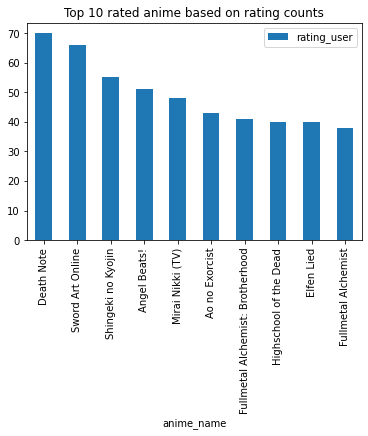

In [24]:
#creating a new dataframe that contains top 10 anime rating counts and showing it in a graph using matplotlib.
anime_fulldata1=pd.merge(data,data2,on='anime_id',suffixes= ['', '_user'])
anime_fulldata1= anime_fulldata1.rename(columns={'name': 'anime_name',})
combine_anime_rating = anime_fulldata1.dropna(axis = 0, subset = ['anime_name'])
anime_ratingCount = (combine_anime_rating.groupby(by = ['anime_name'])['rating_user'].count().reset_index().rename(columns = {'rating': 'totalRatingCount'})[['anime_name', 'rating_user']])
top10_animerating=anime_ratingCount[['anime_name', 'rating_user']].sort_values(by = 'rating_user',ascending = False).head(10)
top10_animerating.plot(title='Top 10 rated anime based on rating counts', kind='bar',x='anime_name',y='rating_user')

In [25]:
#method created to calculate similarity score
def sim_distance(prefs,person1,person2):
    """
    Returns a similar distance between two users' preferences
    """
    si={} 
    for item in prefs[person1]:
        if item in prefs[person2]:
            si[item] = 1
            
    if len(si)==0: # no similarity
        return 0
    
    sum_of_squares = sum([pow(prefs[person1][item]-prefs[person2][item],2) for item in prefs[person1] if item in prefs[person2]])
    return 1/(1+pow(sum_of_squares,0.5))

In [26]:
#converting our dataframe to dictionary
ratings = (df.groupby('user_id')[['anime_name','rating']].apply(lambda x: dict(x.values)).to_dict())

In [27]:
#method created to see top 10 similar users.
def sim_user(prefs, person, n=10, similarity = sim_distance):
    user_score = [(similarity(prefs,person,other), other) for other in prefs if other!=person]         
    user_score.sort()
    user_score.reverse()
    return user_score[0:n]

In [28]:
#method to calculate rating prediction and recommend to users.
def get_recommendations(prefs, person, n=10, similarity = sim_distance):
    totalscore = {} 
    similaritySums = {}
    for other in prefs:
        if other == person:
            continue
        sim = similarity(prefs, person, other)
        if sim <= 0:
            continue
        for item in prefs[other]:
            if item not in prefs[person] or prefs[person][item] == 0:
                totalscore.setdefault(item,0) #returns the value of the item with the specified key
                totalscore[item] += prefs[other][item] * sim #calcutating total ratings
                similaritySums.setdefault(item,0)
                similaritySums[item] += sim   # adding all similarity scores.
    rankings = [(totalscore/similaritySums[item], item) for item, totalscore in totalscore.items()] #getting final prediction rating
    rank=[]
    #creating list contating anime with predicted rating greater than 8.5, for recommendation.
    for i in rankings:
         if i[0] >= 8.5:
            rank.append(i)
    return rank[0:n]

In [30]:
sim_user(ratings,17) #displaying similars users.

[(1.0, 70),
 (1.0, 69),
 (1.0, 42),
 (0.5, 74),
 (0.4142135623730951, 116),
 (0.3333333333333333, 59),
 (0.3333333333333333, 33),
 (0.28989794855663564, 76),
 (0.28989794855663564, 72),
 (0.25, 58)]

In [31]:
#generating recommendation for selected user.
user=17
print('Recommendations for user {}:'.format(user))
get_recommendations(ratings,user)

Recommendations for user 17:


[(8.554777744835382, 'Darker than Black: Kuro no Keiyakusha'),
 (8.706227307135217, '11eyes: Momoiro Genmutan'),
 (8.632154734787749, 'Pokemon: Celebi Toki wo Koeta Deai'),
 (8.620319018034342,
  'Pokemon Diamond &amp; Pearl: Dialga vs. Palkia vs. Darkrai'),
 (9.297079052982493, 'Zetsuen no Tempest'),
 (9.150587880477909, 'Fairy Tail x Rave'),
 (9.25909343661581, 'Hungry Heart: Wild Striker'),
 (8.614155135081228, 'Rurouni Kenshin: Meiji Kenkaku Romantan'),
 (8.503507599634007, 'Dragon Ball'),
 (8.64180560772131, 'Bleach')]